# OVI detection relationship with impact factor

In this notebook we explore whether there is a relationship between the detection of OVI in the galaxy groups, and the projected separation at the group redshift (impact factor) from the quasar from which the absorption features were measured. We also constrast the differences between using our measurements of position and scale radius, and using the positions and radii derived by Stocke et al. 2019 from optical spectra.

## Import Statements

In [1]:
import pandas as pd
from astropy.units import Quantity
import numpy as np
from matplotlib import pyplot as plt

from xga.utils import DEFAULT_COSMO
from xga.sourcetools.misc import ang_to_rad
from xga.utils import r500 as r500_unit
from xga.utils import r2500 as r2500_unit

## Defining useful functions

Here we define any functions that are to be used in this notebook:

In [2]:
# This calculates the separation between two RA-DEC points
def hav_sep(ra, dec, ra2, dec2):
    hav_sep = 2 * np.arcsin(np.sqrt((np.sin(((dec2*(np.pi / 180))-(dec*(np.pi / 180))) / 2) ** 2)
                                    + np.cos((dec * (np.pi / 180))) * np.cos(dec2 * (np.pi / 180))
                                    * np.sin(((ra2*(np.pi / 180)) - (ra*(np.pi / 180))) / 2) ** 2))
    # Converting back to degrees from radians
    hav_sep /= (np.pi / 180)
    return Quantity(hav_sep, 'deg')

## Loading data tables

We have to load several data tables to get the information for this notebook. We start by reading in the information on the quasars that were used to measure the line of sight absorption features. This is primarily to retrieve their name and position; the name will be used to match to the relevant group(s), and the position is used to calculate the impact factor:

In [3]:
quas = pd.read_csv('../../sample_files/quasar_info.csv')
quas = quas.rename(columns={'name': 'quasar_name', 'ra': 'quas_ra', 'dec': 'quas_dec', 
                            'redshift': 'quas_redshift'})
quas

,quasar_name,quas_ra,quas_dec,quas_redshift
0,B1612+266,243.544,26.547,0.395
1,FBQS1519+2838,229.901,28.641,0.270
2,SBS0956+509,149.882,50.747,0.143
3,RBS711,129.245,44.434,0.255
4,FBQSJ1030+3102,157.746,31.049,0.178
5,PHL1811,328.756,-9.373,0.201


This file contains the adopted optical central positions, and optically determined radii used by Stocke et al. - they will be used to contrast the results attained through the use of X-ray derived properties:

In [4]:
opt_groups = pd.read_csv("../../sample_files/opt_group_info.csv")
opt_groups

,name,opt_ra,opt_ra_err,opt_dec,opt_dec_err,redshift,ov_obs_ad,ov_obs_ad_err,r_obs_ad,quasar,OVI_det
0,25124,243.538,0.015,26.687,0.006,0.186,448.0,0.0,1167.0,B1612+266,True
1,44739,229.822,0.019,28.342,0.058,0.118,336.0,0.0,1135.0,FBQS1519+2838,True
2,19670,150.178,0.028,50.784,0.007,0.134,404.0,0.0,991.0,SBS0956+509,False
3,12833,129.400,0.013,44.282,0.010,0.145,444.0,0.0,1396.0,RBS711,False
4,J083829.2+441904.8,NaN,NaN,NaN,NaN,0.198,NaN,NaN,NaN,RBS711,False
5,44858,230.084,0.035,28.873,0.008,0.127,569.0,0.0,1546.0,FBQS1519+2838,True
6,J215504.8-093520,NaN,NaN,NaN,NaN,0.077,630.0,110.0,NaN,PHL1811,True
7,J215437.2-091532.4,NaN,NaN,NaN,NaN,0.077,630.0,110.0,NaN,PHL1811,True
8,50433,157.732,0.003,30.845,0.006,0.136,338.0,0.0,600.0,FBQSJ1030+3102,False


Finally, we read in the data tables containing X-ray properties, both the 'standard mode' and 'frozen temperature mode' results, for $R_{500}$ and $R_{2500}$:

In [5]:
xray_prop = pd.read_csv("../../outputs/results/ltr_r500_pipeline_results.csv")
# xray_prop = pd.read_csv("../../outputs/results/ltr_r500_froztemp_pipeline_results.csv")
xray_prop['opt_name'] = xray_prop['name'].apply(lambda x: x[:5] if len(x) <= 7 else x)

# This makes the merging below a bit neater - means there are no column name clashes, everything is clear, and 
#  we don't duplicate information this is already in another DF (the redshift)
xray_prop = xray_prop.rename(columns={'ra': 'xray_ra', 'dec': 'xray_dec'})
del xray_prop['redshift']
xray_prop

,name,xray_ra,xray_dec,r500,r500+-,Tx500,Tx500-,Tx500+,Lx500_0.5-2.0,Lx500_0.5-2.0-,...,Tx500ce,Tx500ce-,Tx500ce+,Lx500ce_0.5-2.0,Lx500ce_0.5-2.0-,Lx500ce_0.5-2.0+,Lx500ce_0.01-100.0,Lx500ce_0.01-100.0-,Lx500ce_0.01-100.0+,opt_name
0,25124A,243.629055,26.730240,867.647767,39.128436,3.817000,0.287230,0.326195,7.396831e+43,1.360925e+42,...,4.240060,0.463875,0.698658,4.661778e+43,1.474055e+42,1.136021e+42,1.407295e+44,1.243112e+43,8.999482e+42,25124
1,25124B,243.504000,26.691000,665.433860,93.790303,2.121080,0.453657,1.097385,4.858143e+42,5.199192e+41,...,1.668870,0.571085,1.111938,3.756145e+42,5.779736e+41,7.552022e+41,7.921396e+42,1.571571e+42,1.660467e+42,25124
2,25124C,243.541000,26.648000,504.349762,26.563232,1.505450,0.118645,0.157002,4.980125e+42,3.866127e+41,...,1.475180,0.123717,0.146730,4.692879e+42,3.996000e+41,5.333483e+41,9.510069e+42,9.116242e+41,1.309781e+42,25124
3,44739,229.793620,28.331750,426.978169,22.844914,1.024810,0.066587,0.081072,2.328422e+42,2.278838e+41,...,0.993314,0.088181,0.086573,1.873450e+42,2.306554e+41,2.767644e+41,3.233224e+42,3.960150e+41,4.341351e+41,44739
4,19670AB,150.226402,50.800565,527.139938,30.952352,1.978950,0.341111,0.660766,3.495482e+42,3.820188e+41,...,1.561920,0.179030,0.293561,2.992024e+42,3.335254e+41,3.754196e+41,6.209580e+42,1.028791e+42,1.035156e+42,19670
5,19670A,150.256710,50.793942,462.177328,27.670531,1.252010,0.113311,0.139826,1.581114e+42,2.128492e+41,...,1.333620,0.148756,0.199910,1.176707e+42,3.641293e+41,3.858331e+41,2.310265e+42,7.379632e+41,6.230597e+41,19670
6,19670B,150.214920,50.805014,591.610814,44.926843,1.907300,0.243713,0.425694,4.533795e+42,3.011521e+41,...,1.652700,0.244968,0.313360,3.512372e+42,3.266195e+41,5.632695e+41,7.421187e+42,8.747499e+41,8.987884e+41,19670
7,19670C,150.065000,50.746000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19670
8,19670D,150.168000,50.686000,359.762893,58.758058,0.326002,0.070427,0.247115,7.776962e+41,4.208098e+41,...,0.246174,0.060497,0.107147,6.906259e+41,4.756693e+41,1.577939e+41,1.729986e+42,1.048810e+42,5.710794e+41,19670
9,12833A,129.496800,44.248700,484.161429,22.267250,1.394590,0.098024,0.113226,3.419655e+42,4.326240e+41,...,1.416080,0.145301,0.239000,2.240773e+42,3.645432e+41,2.770394e+41,4.498901e+42,7.032202e+41,5.884023e+41,12833


In [6]:
xray_prop_ft = pd.read_csv("../../outputs/results/ltr_r500_froztemp_pipeline_results.csv")
xray_prop_ft['opt_name'] = xray_prop_ft['name'].apply(lambda x: x[:5] if len(x) <= 7 else x)

# This makes the merging below a bit neater - means there are no column name clashes, everything is clear, and 
#  we don't duplicate information this is already in another DF (the redshift)
xray_prop_ft = xray_prop_ft.rename(columns={'ra': 'xray_ra', 'dec': 'xray_dec'})
del xray_prop_ft['redshift']
xray_prop_ft

,name,xray_ra,xray_dec,r500,r500+-,froz_Tx500,froz_Tx500+-,Lx500_0.5-2.0,Lx500_0.5-2.0-,Lx500_0.5-2.0+,Lx500_0.01-100.0,Lx500_0.01-100.0-,Lx500_0.01-100.0+,Lx500ce_0.5-2.0,Lx500ce_0.5-2.0-,Lx500ce_0.5-2.0+,Lx500ce_0.01-100.0,Lx500ce_0.01-100.0-,Lx500ce_0.01-100.0+,opt_name
0,25124A,243.629055,26.730240,872.198366,15.224997,3.880743,0.080516,7.397769e+43,1.259041e+42,1.385235e+42,2.142852e+44,3.792154e+42,4.381067e+42,4.662508e+43,1.195794e+42,1.578949e+42,1.350419e+44,3.806472e+42,2.031262e+42,25124
1,25124B,243.504000,26.691000,532.408815,22.907659,1.635506,0.089537,4.242297e+42,4.368140e+41,4.981882e+41,8.886824e+42,1.006028e+42,1.096658e+42,3.508894e+42,4.570863e+41,3.689955e+41,7.354229e+42,1.274101e+42,1.046026e+42,25124
2,25124C,243.541000,26.648000,572.947058,20.613701,1.875723,0.084899,6.675788e+42,4.855550e+41,5.528316e+41,1.455537e+43,1.119638e+42,1.212101e+42,6.320728e+42,5.077257e+41,3.915620e+41,1.382420e+43,1.258268e+42,1.169624e+42,25124
3,44739,229.793620,28.331750,558.749970,22.452604,1.667937,0.086092,4.031547e+42,3.208988e+41,4.207772e+41,8.554763e+42,7.660734e+41,8.390061e+41,3.536572e+42,3.767249e+41,3.369885e+41,7.499967e+42,9.161629e+41,7.247954e+41,44739
4,19670AB,150.226402,50.800565,532.285811,23.104072,1.556803,0.088600,3.296282e+42,3.306124e+41,3.990340e+41,6.833903e+42,7.590238e+41,7.758412e+41,2.907810e+42,3.668238e+41,3.174720e+41,6.028610e+42,9.183419e+41,7.251984e+41,19670
5,19670A,150.256710,50.793942,467.799981,26.836457,1.249150,0.090908,1.591047e+42,2.354539e+41,3.191889e+41,3.034454e+42,5.194664e+41,5.363645e+41,1.169765e+42,2.894099e+41,2.638983e+41,2.236892e+42,6.617448e+41,4.779989e+41,19670
6,19670B,150.214920,50.805014,562.688861,21.758439,1.733657,0.084967,4.705676e+42,3.432965e+41,4.203984e+41,1.006059e+43,8.372217e+41,8.552070e+41,3.766683e+42,3.954729e+41,3.442119e+41,8.077989e+42,1.000254e+42,7.857269e+41,19670
7,19670C,150.065000,50.746000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19670
8,19670D,150.168000,50.686000,476.465918,26.584040,1.309615,0.100153,1.860376e+42,3.244758e+41,3.837370e+41,3.627001e+42,5.152524e+41,7.013925e+41,1.325715e+42,3.308199e+41,2.862067e+41,2.584773e+42,6.964881e+41,5.620940e+41,19670
9,12833A,129.496800,44.248700,556.703563,21.750504,1.701150,0.085104,4.502962e+42,3.460618e+41,4.579696e+41,9.600239e+42,8.188793e+41,9.084337e+41,3.050146e+42,3.749152e+41,3.278996e+41,6.503218e+42,8.992735e+41,7.012718e+41,12833


In [7]:
xray_prop_r2500 = pd.read_csv("../../outputs/results/ltr_r2500_pipeline_results.csv")

# This makes the merging below a bit neater - means there are no column name clashes, everything is clear, and 
#  we don't duplicate information this is already in another DF (the redshift)
xray_prop_r2500 = xray_prop_r2500.rename(columns={'ra': 'xray_ra', 'dec': 'xray_dec'})

del xray_prop_r2500['redshift']
del xray_prop_r2500['xray_ra']
del xray_prop_r2500['xray_dec']
xray_prop_r2500

,name,r2500,r2500+-,Tx2500,Tx2500-,Tx2500+,Lx2500_0.5-2.0,Lx2500_0.5-2.0-,Lx2500_0.5-2.0+,Lx2500_0.01-100.0,Lx2500_0.01-100.0-,Lx2500_0.01-100.0+
0,25124A,365.267017,12.695384,3.432990,0.199900,0.224862,5.684199e+43,9.328982e+41,7.039906e+41,1.557472e+44,6.391164e+42,5.653323e+42
1,25124B,295.146881,21.744896,2.436460,0.310357,0.501707,4.010473e+42,1.946695e+41,3.563156e+41,9.572086e+42,9.907068e+41,9.034255e+41
2,25124C,277.034520,17.832455,2.127920,0.232797,0.334217,3.508063e+42,2.857552e+41,2.400971e+41,7.990368e+42,7.651462e+41,1.037325e+42
3,44739,194.267792,10.767873,1.039640,0.096475,0.089941,9.528051e+41,9.171794e+40,9.713496e+40,1.678464e+42,1.781575e+41,1.921459e+41
4,19670AB,268.602778,14.841276,1.963400,0.189759,0.250979,2.716377e+42,1.249930e+41,2.240797e+41,6.054734e+42,3.400940e+41,4.140629e+41
5,19670A,226.586944,20.569370,1.336860,0.199435,0.305279,9.952690e+41,1.093715e+41,1.538825e+41,1.955903e+42,3.672504e+41,2.918419e+41
6,19670B,291.763176,18.418645,2.030280,0.189614,0.278329,3.426424e+42,1.232967e+41,2.064824e+41,7.719305e+42,5.850740e+41,5.725601e+41
7,19670C,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,19670D,297.870281,35.940312,2.660770,0.628359,1.435512,2.032401e+42,1.613658e+41,2.507279e+41,5.028950e+42,8.245194e+41,1.005192e+42
9,12833A,225.358513,8.326291,1.407540,0.064927,0.073594,3.001651e+42,1.847982e+41,1.956755e+41,6.013372e+42,3.462115e+41,3.562511e+41


In [8]:
xray_prop_r2500_ft = pd.read_csv("../../outputs/results/ltr_r2500_froztemp_pipeline_results.csv")

# This makes the merging below a bit neater - means there are no column name clashes, everything is clear, and 
#  we don't duplicate information this is already in another DF (the redshift)
xray_prop_r2500_ft = xray_prop_r2500_ft.rename(columns={'ra': 'xray_ra', 'dec': 'xray_dec'})

del xray_prop_r2500_ft['redshift']
del xray_prop_r2500_ft['xray_ra']
del xray_prop_r2500_ft['xray_dec']
xray_prop_r2500_ft

,name,r2500,r2500+-,froz_Tx2500,froz_Tx2500+-,Lx2500_0.5-2.0,Lx2500_0.5-2.0-,Lx2500_0.5-2.0+,Lx2500_0.01-100.0,Lx2500_0.01-100.0-,Lx2500_0.01-100.0+,Lx2500ce_0.5-2.0,Lx2500ce_0.5-2.0-,Lx2500ce_0.5-2.0+,Lx2500ce_0.01-100.0,Lx2500ce_0.01-100.0-,Lx2500ce_0.01-100.0+
0,25124A,406.098661,6.011248,4.193594,0.088298,5.908126e+43,8.832664e+41,8.732593e+41,1.774270e+44,2.936787e+42,2.963377e+42,4.788077e+43,7.515814e+41,6.383893e+41,1.437908e+44,2.714184e+42,2.842512e+42
1,25124B,260.889130,9.193033,1.902899,0.095089,3.401583e+42,2.164596e+41,2.368561e+41,7.473568e+42,3.942254e+41,6.090672e+41,3.148056e+42,2.103764e+41,2.083159e+41,6.916549e+42,5.381786e+41,6.580555e+41
2,25124C,253.115356,9.260529,1.802835,0.092291,2.712534e+42,1.987174e+41,2.118727e+41,5.859928e+42,4.961770e+41,4.904011e+41,2.538199e+42,1.903769e+41,1.822075e+41,5.483309e+42,5.029589e+41,5.081750e+41
3,44739,248.621670,10.026870,1.640180,0.094824,1.747884e+42,1.283327e+41,1.396112e+41,3.687753e+42,2.427658e+41,3.238879e+41,1.432576e+42,1.150398e+41,1.190681e+41,3.022505e+42,2.762640e+41,3.403309e+41
4,19670AB,260.957574,9.611045,1.814351,0.094867,2.586114e+42,1.531568e+41,1.613719e+41,5.624593e+42,2.983787e+41,4.175828e+41,2.516956e+42,1.488378e+41,1.395956e+41,5.474179e+42,3.615612e+41,4.784222e+41
5,19670A,226.261169,10.571603,1.406302,0.093241,1.012175e+42,1.217848e+41,1.284063e+41,2.026928e+42,2.110059e+41,2.441474e+41,7.147757e+41,1.080485e+41,1.034120e+41,1.431372e+42,2.646080e+41,2.673522e+41
6,19670B,265.514870,9.458204,1.871320,0.094624,2.899008e+42,1.626719e+41,1.719465e+41,6.365236e+42,3.046325e+41,4.335280e+41,2.645034e+42,1.483424e+41,1.434989e+41,5.807596e+42,3.627009e+41,4.791751e+41
7,19670C,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,19670D,248.199415,10.140733,1.659005,0.097961,1.897731e+42,1.690925e+41,1.926925e+41,4.014343e+42,3.319839e+41,4.323404e+41,1.768472e+42,1.609629e+41,1.623374e+41,3.740917e+42,3.877538e+41,4.876737e+41
9,12833A,270.612558,9.269351,1.955483,0.094645,3.475465e+42,2.068244e+41,1.927716e+41,7.737077e+42,3.927438e+41,5.874377e+41,2.880157e+42,1.726556e+41,1.646949e+41,6.411802e+42,4.306175e+41,5.675991e+41


Combining the quasar information, optical group, and X-ray group tables:

In [9]:
comb = pd.merge(quas, opt_groups, left_on='quasar_name', right_on='quasar', how='outer')
comb = pd.merge(comb, xray_prop, left_on='name', right_on='opt_name')
del comb['opt_name']
del comb['name_x']
comb = comb.rename(columns={'name_y': 'name'})
comb = pd.merge(comb, xray_prop_r2500, left_on='name', right_on='name')
comb

,quasar_name,quas_ra,quas_dec,quas_redshift,opt_ra,opt_ra_err,opt_dec,opt_dec_err,redshift,ov_obs_ad,...,r2500+-,Tx2500,Tx2500-,Tx2500+,Lx2500_0.5-2.0,Lx2500_0.5-2.0-,Lx2500_0.5-2.0+,Lx2500_0.01-100.0,Lx2500_0.01-100.0-,Lx2500_0.01-100.0+
0,B1612+266,243.544,26.547,0.395,243.538,0.015,26.687,0.006,0.186,448.0,...,12.695384,3.432990,0.199900,0.224862,5.684199e+43,9.328982e+41,7.039906e+41,1.557472e+44,6.391164e+42,5.653323e+42
1,B1612+266,243.544,26.547,0.395,243.538,0.015,26.687,0.006,0.186,448.0,...,21.744896,2.436460,0.310357,0.501707,4.010473e+42,1.946695e+41,3.563156e+41,9.572086e+42,9.907068e+41,9.034255e+41
2,B1612+266,243.544,26.547,0.395,243.538,0.015,26.687,0.006,0.186,448.0,...,17.832455,2.127920,0.232797,0.334217,3.508063e+42,2.857552e+41,2.400971e+41,7.990368e+42,7.651462e+41,1.037325e+42
3,FBQS1519+2838,229.901,28.641,0.270,229.822,0.019,28.342,0.058,0.118,336.0,...,10.767873,1.039640,0.096475,0.089941,9.528051e+41,9.171794e+40,9.713496e+40,1.678464e+42,1.781575e+41,1.921459e+41
4,FBQS1519+2838,229.901,28.641,0.270,230.084,0.035,28.873,0.008,0.127,569.0,...,11.473868,2.378740,0.141971,0.175942,1.629426e+43,4.836574e+41,6.565397e+41,3.874151e+43,1.282503e+42,1.365023e+42
5,FBQSJ1030+3102,157.746,31.049,0.178,157.732,0.003,30.845,0.006,0.136,338.0,...,8.630310,1.202160,0.062874,0.079467,2.389853e+42,1.692117e+41,1.929285e+41,4.500083e+42,3.646457e+41,4.092444e+41
6,PHL1811,328.756,-9.373,0.201,NaN,NaN,NaN,NaN,0.077,630.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,PHL1811,328.756,-9.373,0.201,NaN,NaN,NaN,NaN,0.077,630.0,...,6.914542,0.750645,0.022777,0.039442,3.154118e+41,5.106595e+40,5.656441e+40,4.981166e+41,8.803647e+40,9.243184e+40
8,RBS711,129.245,44.434,0.255,129.400,0.013,44.282,0.010,0.145,444.0,...,8.326291,1.407540,0.064927,0.073594,3.001651e+42,1.847982e+41,1.956755e+41,6.013372e+42,3.462115e+41,3.562511e+41
9,RBS711,129.245,44.434,0.255,129.400,0.013,44.282,0.010,0.145,444.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


We do the same thing separately for the frozen temperature results, as they would have a lot of clashing column names:

In [10]:
comb_ft = pd.merge(quas, opt_groups, left_on='quasar_name', right_on='quasar', how='outer')
comb_ft = pd.merge(comb_ft, xray_prop_ft, left_on='name', right_on='opt_name')
del comb_ft['opt_name']
del comb_ft['name_x']
comb_ft = comb_ft.rename(columns={'name_y': 'name'})
comb_ft = pd.merge(comb_ft, xray_prop_r2500_ft, left_on='name', right_on='name')
comb_ft

,quasar_name,quas_ra,quas_dec,quas_redshift,opt_ra,opt_ra_err,opt_dec,opt_dec_err,redshift,ov_obs_ad,...,Lx2500_0.5-2.0+,Lx2500_0.01-100.0,Lx2500_0.01-100.0-,Lx2500_0.01-100.0+,Lx2500ce_0.5-2.0,Lx2500ce_0.5-2.0-,Lx2500ce_0.5-2.0+,Lx2500ce_0.01-100.0,Lx2500ce_0.01-100.0-,Lx2500ce_0.01-100.0+
0,B1612+266,243.544,26.547,0.395,243.538,0.015,26.687,0.006,0.186,448.0,...,8.732593e+41,1.774270e+44,2.936787e+42,2.963377e+42,4.788077e+43,7.515814e+41,6.383893e+41,1.437908e+44,2.714184e+42,2.842512e+42
1,B1612+266,243.544,26.547,0.395,243.538,0.015,26.687,0.006,0.186,448.0,...,2.368561e+41,7.473568e+42,3.942254e+41,6.090672e+41,3.148056e+42,2.103764e+41,2.083159e+41,6.916549e+42,5.381786e+41,6.580555e+41
2,B1612+266,243.544,26.547,0.395,243.538,0.015,26.687,0.006,0.186,448.0,...,2.118727e+41,5.859928e+42,4.961770e+41,4.904011e+41,2.538199e+42,1.903769e+41,1.822075e+41,5.483309e+42,5.029589e+41,5.081750e+41
3,FBQS1519+2838,229.901,28.641,0.270,229.822,0.019,28.342,0.058,0.118,336.0,...,1.396112e+41,3.687753e+42,2.427658e+41,3.238879e+41,1.432576e+42,1.150398e+41,1.190681e+41,3.022505e+42,2.762640e+41,3.403309e+41
4,FBQS1519+2838,229.901,28.641,0.270,230.084,0.035,28.873,0.008,0.127,569.0,...,6.249728e+41,4.720825e+43,1.458863e+42,1.889415e+42,1.539602e+43,5.041021e+41,5.357920e+41,4.054411e+43,1.469206e+42,1.973914e+42
5,FBQSJ1030+3102,157.746,31.049,0.178,157.732,0.003,30.845,0.006,0.136,338.0,...,1.869437e+41,5.797288e+42,3.901083e+41,5.839601e+41,2.180884e+42,2.180064e+41,1.684802e+41,4.761941e+42,4.873856e+41,5.259787e+41
6,PHL1811,328.756,-9.373,0.201,NaN,NaN,NaN,NaN,0.077,630.0,...,2.425141e+41,1.844060e+43,7.600723e+41,8.825033e+41,5.646341e+42,2.489706e+41,2.038891e+41,1.423792e+43,5.791577e+41,6.618353e+41
7,PHL1811,328.756,-9.373,0.201,NaN,NaN,NaN,NaN,0.077,630.0,...,6.811378e+40,6.791156e+41,1.014206e+41,1.223269e+41,1.419073e+41,5.925401e+40,7.227321e+40,2.564735e+41,1.417362e+41,1.144950e+41
8,RBS711,129.245,44.434,0.255,129.400,0.013,44.282,0.010,0.145,444.0,...,1.927716e+41,7.737077e+42,3.927438e+41,5.874377e+41,2.880157e+42,1.726556e+41,1.646949e+41,6.411802e+42,4.306175e+41,5.675991e+41
9,RBS711,129.245,44.434,0.255,129.400,0.013,44.282,0.010,0.145,444.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
comb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16 entries, 0 to 15
Data columns (total 48 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   quasar_name          16 non-null     object 
 1   quas_ra              16 non-null     float64
 2   quas_dec             16 non-null     float64
 3   quas_redshift        16 non-null     float64
 4   opt_ra               13 non-null     float64
 5   opt_ra_err           13 non-null     float64
 6   opt_dec              13 non-null     float64
 7   opt_dec_err          13 non-null     float64
 8   redshift             16 non-null     float64
 9   ov_obs_ad            15 non-null     float64
 10  ov_obs_ad_err        15 non-null     float64
 11  r_obs_ad             13 non-null     float64
 12  quasar               16 non-null     object 
 13  OVI_det              16 non-null     bool   
 14  name                 16 non-null     object 
 15  xray_ra              16 non-null     float

## Calculating impact factors

We perform the simple calculation (using Haversine, but it would probably have been fine just assuming Euclidean) of the separation of the quasar sightlines, and their foreground groups. The angular separation is then converted to a proper distance using our chosen cosmology, and at the redshift of the groups.

### From X-ray group positions

Firstly, we use our newly defined group positions from X-ray data: 

In [12]:
xray_deg_seps = hav_sep(comb['quas_ra'].values, comb['quas_dec'].values, comb['xray_ra'].values, 
                        comb['xray_dec'].values)
xray_kpc_seps = ang_to_rad(xray_deg_seps, comb['redshift'].values, DEFAULT_COSMO)
xray_kpc_seps

<Quantity [2225.22177208, 1664.25483944, 1133.27948289, 2481.6492767 ,
           2521.58383381, 1623.38709296, 1135.29427505,  795.00116405,
           2364.03570933, 1400.70740661, 3457.54758192, 1919.83562146,
           2067.90029753, 1869.21459417,  991.21277217, 1635.62575473] kpc>

The measured $R_{500}$ and $R_{2500}$ values are then used to put the impact factor in terms of a physically motivated scale radius:

In [13]:
r500 = Quantity(comb['r500'], 'kpc') / Quantity(1, r500_unit)
r500_err = Quantity(comb['r500+-'], 'kpc') / Quantity(1, r500_unit)
r2500 = Quantity(comb['r2500'], 'kpc') / Quantity(1, r500_unit)
r2500_err = Quantity(comb['r2500+-'], 'kpc') / Quantity(1, r500_unit)

r500_ft = Quantity(comb_ft['r500'], 'kpc') / Quantity(1, r500_unit)
r500_ft_err = Quantity(comb_ft['r500+-'], 'kpc') / Quantity(1, r500_unit)
r2500_ft = Quantity(comb_ft['r2500'], 'kpc') / Quantity(1, r500_unit)
r2500_ft_err = Quantity(comb_ft['r2500+-'], 'kpc') / Quantity(1, r500_unit)

In [14]:
xr500_scale_imp_fac = xray_kpc_seps / r500
xr500_scale_imp_fac_err = (xray_kpc_seps * r500_err) / (r500**2)
xr500_scale_imp_fac

xr500_ft_scale_imp_fac = xray_kpc_seps / r500_ft
xr500_ft_scale_imp_fac_err = (xray_kpc_seps * r500_ft_err) / (r500**2)
xr500_ft_scale_imp_fac

<Quantity [2.55127946, 3.12589648, 1.9779829 , 4.44143071, 3.30363311,
           3.1487405 , 1.74616222, 2.01467626, 4.24648928, 2.73662423,
                  nan, 3.60677587, 4.42047965, 3.32193282,        nan,
           3.43282844] r500>

In [15]:
xr2500_scale_imp_fac = xray_kpc_seps / r2500
xr2500_scale_imp_fac_err = (xray_kpc_seps * r2500_err) / (r2500**2)
xr2500_scale_imp_fac

xr2500_ft_scale_imp_fac = xray_kpc_seps / r2500_ft
xr2500_ft_scale_imp_fac_err = (xray_kpc_seps * r2500_ft_err) / (r500**2)
xr2500_ft_scale_imp_fac

<Quantity [5.47951024, 6.37916512, 4.47732409, 9.98162902, 7.12423609,
           6.18952454, 3.54457687, 3.93732715, 8.73586845,        nan,
                  nan, 7.3568879 , 9.13943964, 7.03996199,        nan,
           6.5899662 ] r500>

Showing the fractional impact factor errors:

In [16]:
xr500_scale_imp_fac_err / xr500_scale_imp_fac

<Quantity [0.04509714, 0.14094609, 0.05266828, 0.05350371, 0.04083566,
           0.04799065, 0.03513944, 0.04640839, 0.04599138, 0.06054174,
                  nan, 0.05871752, 0.05986995, 0.07593986,        nan,
           0.1633244 ]>

In [17]:
xr2500_scale_imp_fac_err / xr2500_scale_imp_fac

<Quantity [0.03475645, 0.07367483, 0.06436907, 0.05542799, 0.03739637,
           0.04169507,        nan, 0.04093585, 0.03694687,        nan,
                  nan, 0.05525362, 0.09077915, 0.06312875,        nan,
           0.1206576 ]>

### From optical group positions

We also perform the same operation, but with optically defined central positions:

In [18]:
opt_deg_seps = hav_sep(comb['quas_ra'].values, comb['quas_dec'].values, comb['opt_ra'].values, 
                        comb['opt_dec'].values)
opt_kpc_seps = ang_to_rad(opt_deg_seps, comb['redshift'].values, DEFAULT_COSMO)
opt_kpc_seps

<Quantity [1571.48092446, 1571.48092446, 1571.48092446, 2355.96361568,
           2306.43953805, 1771.35245319,           nan,           nan,
           1721.03109292, 1721.03109292,           nan, 1633.55814654,
           1633.55814654, 1633.55814654, 1633.55814654, 1633.55814654] kpc>

Reading out the $R_{obs}$ radii from Stocke et al. 2019; though this radius has little physical meaning:

In [19]:
opt_r = Quantity(comb['r_obs_ad'], 'kpc')

In [20]:
opt_scale_imp_fac = opt_kpc_seps / opt_r
opt_scale_imp_fac

<Quantity [1.34659891, 1.34659891, 1.34659891, 2.07573887, 1.49187551,
           2.95225409,        nan,        nan, 1.2328303 , 1.2328303 ,
                  nan, 1.64839369, 1.64839369, 1.64839369, 1.64839369,
           1.64839369]>

## Comparing X-ray and optical radii and impact parameters

We briefly compare the measurements of radius and impact factor from X-ray and optical analyses.

### Measurements of radius

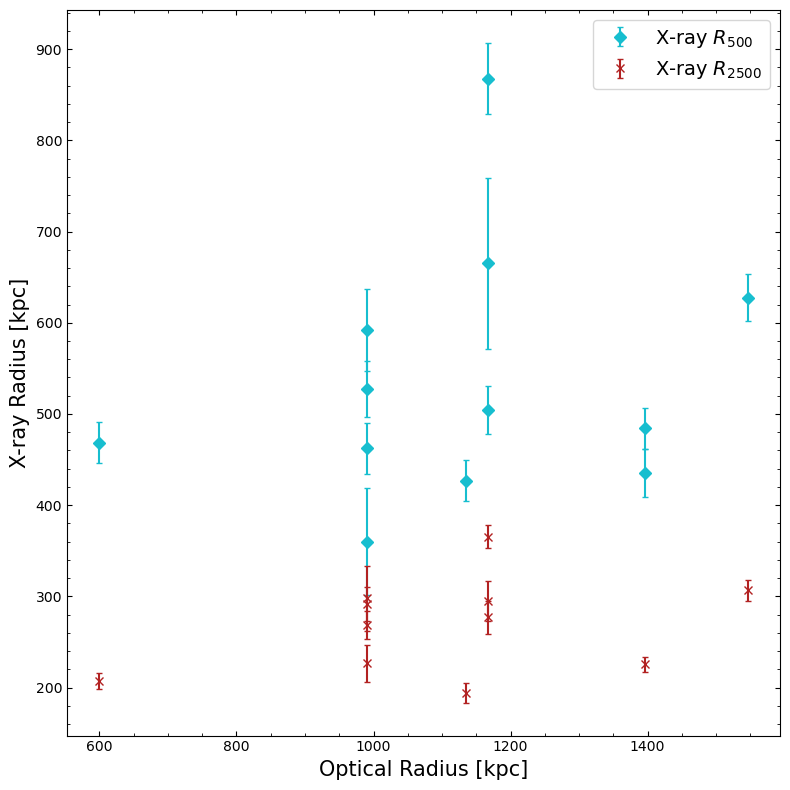

In [21]:
plt.figure(figsize=(8, 8))
plt.minorticks_on()
plt.tick_params(which='both', direction='in', top=True, right=True)

plt.errorbar(opt_r.value, r500.value, yerr=r500_err.value, fmt='D', capsize=2, color='tab:cyan', 
             label=r"X-ray $R_{500}$")
plt.errorbar(opt_r.value, r2500.value, yerr=r2500_err.value, capsize=2, fmt='x', color='firebrick', 
             label=r"X-ray $R_{2500}$")

# plt.xlim(100, 1500)
# plt.ylim(100, 1000)

plt.xlabel("Optical Radius [kpc]", fontsize=15)
plt.ylabel("X-ray Radius [kpc]", fontsize=15)

# plt.xscale('log')
# plt.yscale('log')

plt.legend(fontsize=14)
plt.tight_layout()
plt.show()

### Measurements of impact parameter

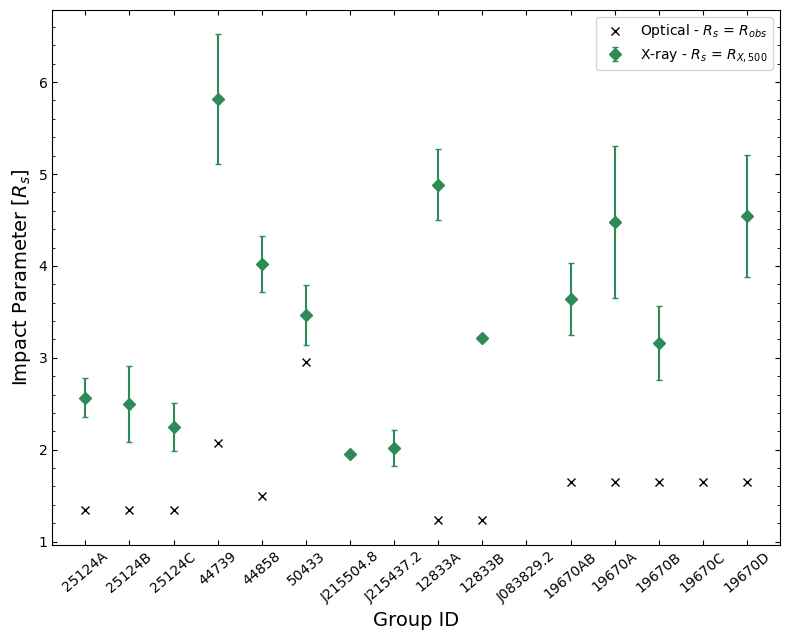

In [22]:
names = comb['name'].values

x_offset = 0.08

plt.figure(figsize=(8, 6.5))
plt.minorticks_on()
plt.tick_params(which='both', direction='in', top=True, right=True)
plt.tick_params(which='minor', axis='x', bottom=False, top=False)

plt.plot(range(len(names)), opt_scale_imp_fac, 'x', label=r"Optical - $R_{s}$ = $R_{obs}$", 
         color='black')
# plt.plot(range(len(names)), xr500_scale_imp_fac, 'D', label="X-ray - $R_{s}$ = $R_{X,500}$", 
#          color='seagreen')
plt.errorbar(range(len(names)), xr500_scale_imp_fac.value, yerr=xr2500_scale_imp_fac_err.value, fmt='D', 
             label="X-ray - $R_{s}$ = $R_{X,500}$", color='seagreen', capsize=2)

# plt.plot(range(len(names)), xr2500_scale_imp_fac, 'o', label="X-ray - $R_{s}$ = $R_{X,2500}$", 
#          color='goldenrod')

plt.ylabel(r"Impact Parameter [$R_{s}$]", fontsize=14)
plt.xlabel('Group ID', fontsize=14)

rel_names = [n.split('-')[0].split('+')[0] for n in names]
plt.xticks(ticks=range(len(names)), labels=rel_names)
ax = plt.gca()
for label in ax.get_xticklabels(which='major'):
    label.set(rotation=40, horizontalalignment='center')

plt.legend()
plt.tight_layout()

plt.savefig('../../outputs/figures/impact_parameter_comp.pdf')
plt.show()

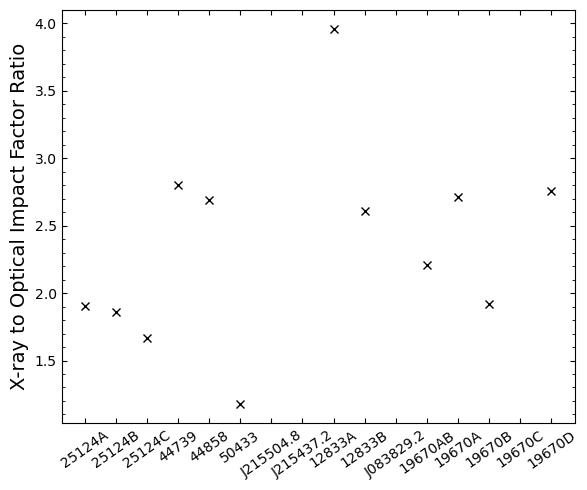

In [23]:
names = comb['name'].values

x_offset = 0.08

plt.figure(figsize=(6, 5))
plt.minorticks_on()
plt.tick_params(which='both', direction='in', top=True, right=True)
plt.tick_params(which='minor', axis='x', bottom=False, top=False)

plt.plot(range(len(names)), xr500_scale_imp_fac / opt_scale_imp_fac, 'x', 
         color='black')


plt.ylabel(r"X-ray to Optical Impact Factor Ratio", fontsize=14)

chos_names = [n.split('-')[0].split('+')[0] if 'J' in n else n for n in names]
plt.xticks(ticks=range(len(names)), labels=chos_names)
ax = plt.gca()
for label in ax.get_xticklabels(which='major'):
    label.set(rotation=35, horizontalalignment='center')

# plt.legend()
plt.tight_layout()

plt.show()

## OVI Detection

In [24]:
y_stop_start = {'25124A': [0.40, 0.58], '25124B': [0.40, 0.58], '25124C': [0.40, 0.58], 
                '44739': [0.41, 0.57], '44858': [0.41, 0.57], 
                '19670A': [0.40, 0.58], '19670B': [0.40, 0.58], '19670C': [0.40, 0.58], '19670D': [0.40, 0.58], 
                '19670AB': [0.39, 0.59],
                '12833A': [0.40, 0.58], '12833B': [0.40, 0.58], 
                'J083829.2': [0.38, 0.61],
                '50433': [0.41, 0.57], 
                'J215504.8': [0.38, 0.61],
                'J215437.2': [0.38, 0.61]}

### XGA-LTR Standard Mode

Finally, we make figures to present whether an O VI detection has any relationship with the impact parameter of group center from quasar. The figures in this section use results from the 'standard mode' run of the XGA-LTR pipeline, which allows temperature to vary during spectral fits:

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


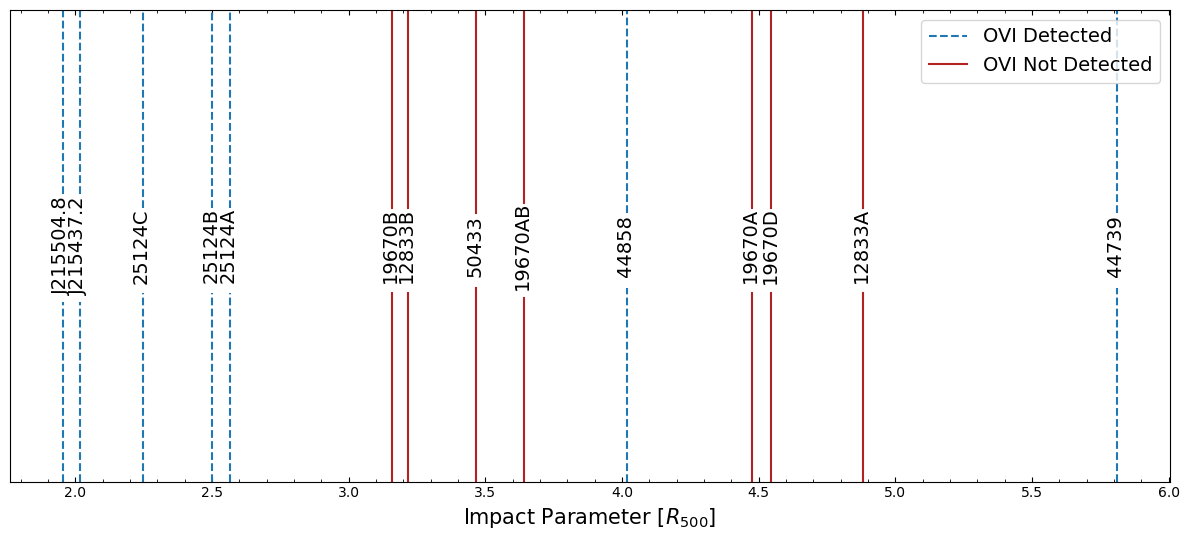

In [25]:
plt.figure(figsize=(12, 5.5))
ax = plt.gca()

plt.minorticks_on()
plt.tick_params(which='both', direction='in', top=True, right=True)

plt.xlabel(r'Impact Parameter [$R_{500}$]', fontsize=15)

det_lab = False
not_det_lab = False
for row_ind, row in comb.iterrows():
    rel_name = row['name'].split('-')[0].split('+')[0]
    d_rad = xr500_scale_imp_fac[row_ind].value
    ax.annotate(rel_name, (d_rad - 0.04, 0.5), rotation=90, verticalalignment='center',
                             color='black', fontsize=14, xycoords=('data', 'axes fraction'))
    if row['OVI_det']:
        if not det_lab:
            lab = 'OVI Detected'
            det_lab = True
        else:
            lab = ''
        plt.axvline(d_rad, color='tab:blue', linestyle='dashed', 
                    label=lab, ymax=y_stop_start[rel_name][0])
        plt.axvline(d_rad, color='tab:blue', linestyle='dashed', ymin=y_stop_start[rel_name][1], ymax=1)
    else:
        if not not_det_lab:
            lab = 'OVI Not Detected'
            not_det_lab = True
            
        else:
            lab = ''
        plt.axvline(d_rad, color='firebrick', label=lab, ymax=y_stop_start[rel_name][0])
        plt.axvline(d_rad, color='firebrick', ymin=y_stop_start[rel_name][1], ymax=1)
        

plt.yticks([])
plt.legend(loc=1, fontsize=14)
        
plt.tight_layout()
plt.savefig("../../outputs/figures/xray_r500_impact_par.pdf")
plt.show()

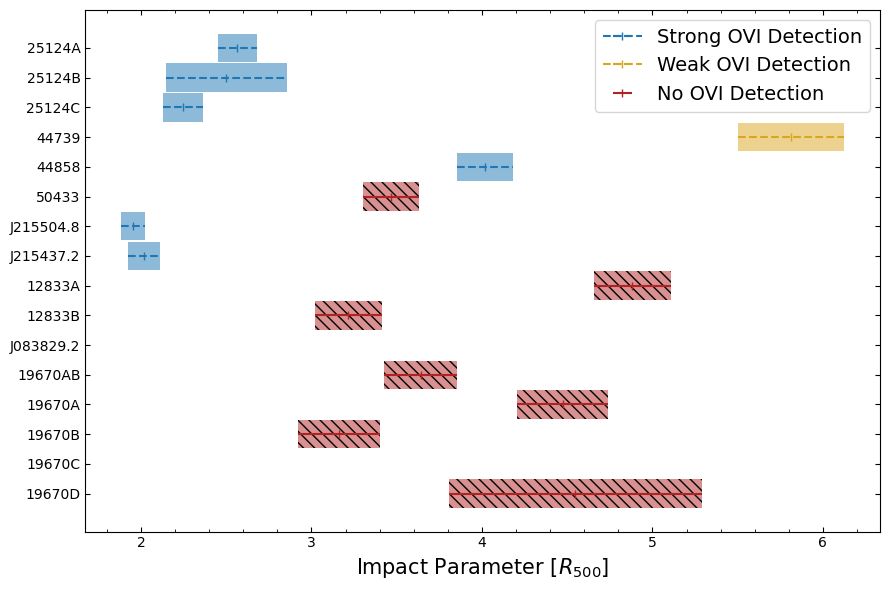

In [26]:
plt.figure(figsize=(9, 6))
ax = plt.gca()

plt.minorticks_on()
plt.tick_params(which='both', direction='in', top=True, right=True)
plt.tick_params(axis='y', which='minor', width=0)

plt.xlabel(r'Impact Parameter [$R_{500}$]', fontsize=15)

det_lab = False
not_det_lab = False
for row_ind, row in comb.iterrows():
    rel_name = row['name'].split('-')[0].split('+')[0]
    d_rad = xr500_scale_imp_fac[row_ind].value
    d_rad_err = xr500_scale_imp_fac_err[row_ind].value
#     plt.axhline(row_ind-0.48, linestyle='dotted', color='tab:grey')
    
    if np.isnan(d_rad):
        continue

    if row['OVI_det']:
        if not det_lab:
            lab = 'Strong OVI Detection'
            det_lab = True
        else:
            lab = ''

        # This is a pretty shoddy way of doing this, but ah well
        if rel_name != '44739':
            errs = plt.errorbar(d_rad, row_ind, xerr=d_rad_err, fmt='|', color='tab:blue', linestyle='dashed', 
                                label=lab, capsize=0)
            errs[-1][0].set_linestyle('--')
            ax.fill_between([d_rad-d_rad_err, d_rad+d_rad_err], row_ind-0.48, row_ind+0.48, 
                                facecolor='tab:blue', alpha=0.5, interpolate=True)
        else:
            errs = plt.errorbar(d_rad, row_ind, xerr=d_rad_err, fmt='|', color='goldenrod', linestyle='dashed', 
                            label="Weak OVI Detection", capsize=0)
            errs[-1][0].set_linestyle('--')
            ax.fill_between([d_rad-d_rad_err, d_rad+d_rad_err], row_ind-0.48, row_ind+0.48, 
                            facecolor='goldenrod', alpha=0.5, interpolate=True)
    else:
        if not not_det_lab:
            lab = 'No OVI Detection'
            not_det_lab = True
            
        else:
            lab = ''
        plt.errorbar(d_rad, row_ind, xerr=d_rad_err, fmt='|', color='firebrick', 
                    label=lab, capsize=0)
        ax.fill_between([d_rad-d_rad_err, d_rad+d_rad_err], row_ind-0.48, row_ind+0.48, 
                            facecolor='firebrick', alpha=0.5, interpolate=True, hatch="\\\\\\")
#     plt.axhspan(row_ind-0.48, row_ind+0.48, facecolor='none', edgecolor='black', linestyle='dotted')

chos_names = [n.split('-')[0].split('+')[0] if 'J' in n else n for n in comb['name'].values]
plt.yticks(ticks=range(len(comb)), labels=chos_names)
ax.invert_yaxis()
plt.legend(loc='best', fontsize=14)

plt.tight_layout()
plt.savefig("../../outputs/figures/xray_r500_impact_par_werr.pdf")
plt.show()

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


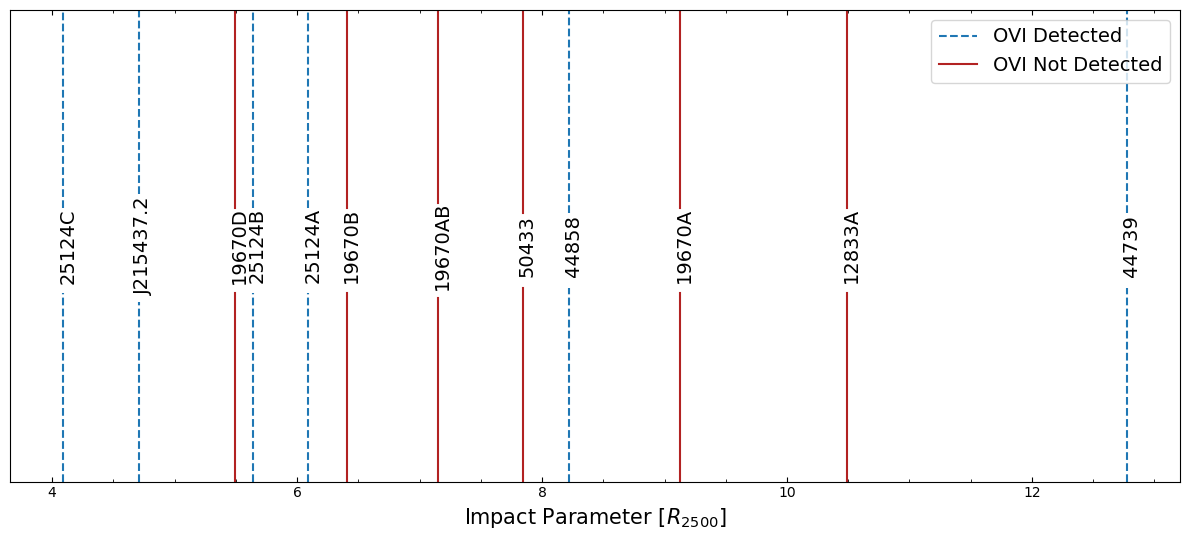

In [27]:
plt.figure(figsize=(12, 5.5))
ax = plt.gca()

plt.minorticks_on()
plt.tick_params(which='both', direction='in', top=True, right=True)

plt.xlabel(r'Impact Parameter [$R_{2500}$]', fontsize=15)

det_lab = False
not_det_lab = False
for row_ind, row in comb.iterrows():
    rel_name = row['name'].split('-')[0].split('+')[0]
    
    d_rad = xr2500_scale_imp_fac[row_ind].value
    ax.annotate(rel_name, (d_rad - 0.04, 0.5), rotation=90, verticalalignment='center', 
                color='black', fontsize=14, xycoords=('data', 'axes fraction'))
    if row['OVI_det']:
        if not det_lab:
            lab = 'OVI Detected'
            det_lab = True
        else:
            lab = ''
        plt.axvline(d_rad, color='tab:blue', linestyle='dashed', 
                    label=lab, ymax=y_stop_start[rel_name][0])
        plt.axvline(d_rad, color='tab:blue', linestyle='dashed', ymin=y_stop_start[rel_name][1], ymax=1)
    else:
        if not not_det_lab:
            lab = 'OVI Not Detected'
            not_det_lab = True
            
        else:
            lab = ''
        plt.axvline(d_rad, color='firebrick', label=lab, ymax=y_stop_start[rel_name][0])
        plt.axvline(d_rad, color='firebrick', ymin=y_stop_start[rel_name][1], ymax=1)
        

plt.yticks([])
plt.legend(loc=1, fontsize=14)
        
plt.tight_layout()
plt.savefig("../../outputs/figures/xray_r2500_impact_par.pdf")
plt.show()

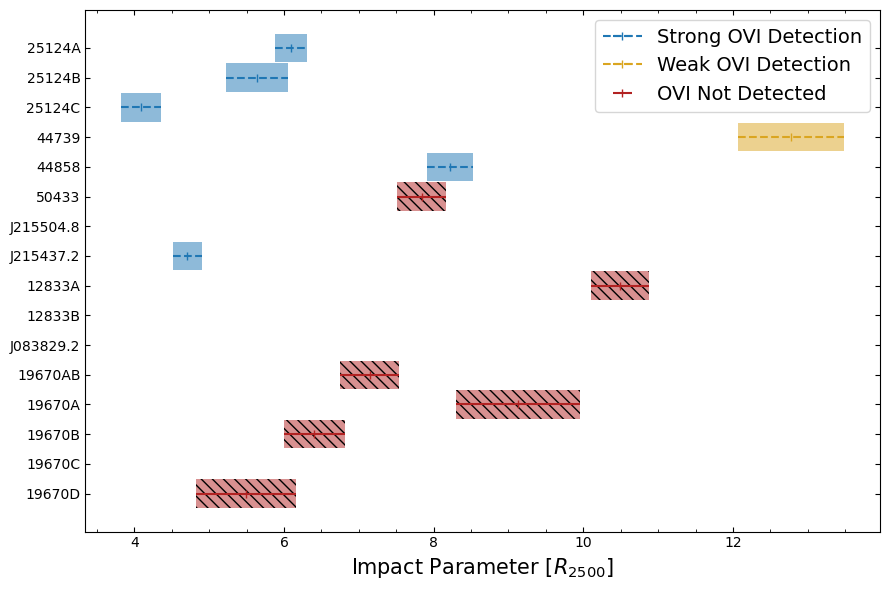

In [28]:
plt.figure(figsize=(9, 6))
ax = plt.gca()

plt.minorticks_on()
plt.tick_params(which='both', direction='in', top=True, right=True)
plt.tick_params(axis='y', which='minor', width=0)

plt.xlabel(r'Impact Parameter [$R_{2500}$]', fontsize=15)

det_lab = False
not_det_lab = False
for row_ind, row in comb.iterrows():
    rel_name = row['name'].split('-')[0].split('+')[0]
    d_rad = xr2500_scale_imp_fac[row_ind].value
    d_rad_err = xr2500_scale_imp_fac_err[row_ind].value
#     plt.axhline(row_ind-0.48, linestyle='dotted', color='tab:grey')
    
    if np.isnan(d_rad):
        continue




    if row['OVI_det']:
        if not det_lab:
            lab = 'Strong OVI Detection'
            det_lab = True
        else:
            lab = ''

        # This is a pretty shoddy way of doing this, but ah well
        if rel_name != '44739':
            errs = plt.errorbar(d_rad, row_ind, xerr=d_rad_err, fmt='|', color='tab:blue', linestyle='dashed', 
                                label=lab, capsize=0)
            errs[-1][0].set_linestyle('--')
            ax.fill_between([d_rad-d_rad_err, d_rad+d_rad_err], row_ind-0.48, row_ind+0.48, 
                                facecolor='tab:blue', alpha=0.5, interpolate=True)
        else:
            errs = plt.errorbar(d_rad, row_ind, xerr=d_rad_err, fmt='|', color='goldenrod', linestyle='dashed', 
                            label="Weak OVI Detection", capsize=0)
            errs[-1][0].set_linestyle('--')
            ax.fill_between([d_rad-d_rad_err, d_rad+d_rad_err], row_ind-0.48, row_ind+0.48, 
                            facecolor='goldenrod', alpha=0.5, interpolate=True)
    else:
        if not not_det_lab:
            lab = 'OVI Not Detected'
            not_det_lab = True
            
        else:
            lab = ''
        plt.errorbar(d_rad, row_ind, xerr=d_rad_err, fmt='|', color='firebrick', 
                    label=lab, capsize=0)
        ax.fill_between([d_rad-d_rad_err, d_rad+d_rad_err], row_ind-0.48, row_ind+0.48, 
                            facecolor='firebrick', alpha=0.5, interpolate=True, hatch="\\\\\\")
#     plt.axhspan(row_ind-0.48, row_ind+0.48, facecolor='none', edgecolor='black', linestyle='dotted')

chos_names = [n.split('-')[0].split('+')[0] if 'J' in n else n for n in comb['name'].values]
plt.yticks(ticks=range(len(comb)), labels=chos_names)
ax.invert_yaxis()
plt.legend(loc='best', fontsize=14)

plt.tight_layout()
plt.savefig("../../outputs/figures/xray_r2500_impact_par_werr.pdf")
plt.show()

### XGA-LTR Frozen Temperature Mode

Here we essentially copy the last section, but use the results measured during the frozen temperature mode run of the XGA-LTR, which may perform better for very low signal-to-noise galaxy groups/clusters - frozen temperature mode does not allow the temperature to vary during spectral fits:

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


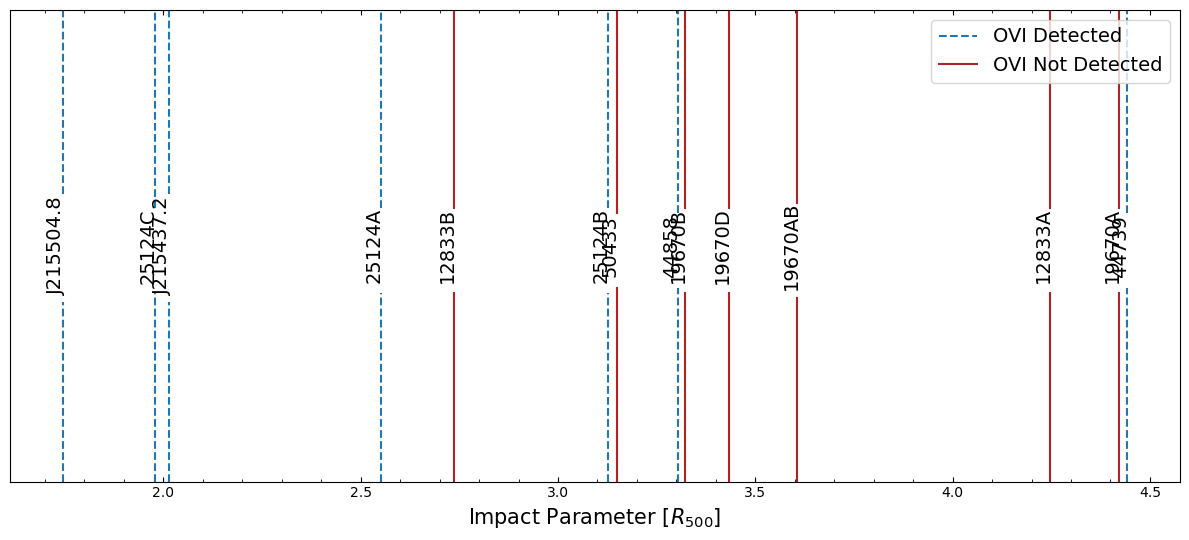

In [29]:
plt.figure(figsize=(12, 5.5))
ax = plt.gca()

plt.minorticks_on()
plt.tick_params(which='both', direction='in', top=True, right=True)

plt.xlabel(r'Impact Parameter [$R_{500}$]', fontsize=15)

det_lab = False
not_det_lab = False
for row_ind, row in comb_ft.iterrows():
    rel_name = row['name'].split('-')[0].split('+')[0]
    d_rad = xr500_ft_scale_imp_fac[row_ind].value
    ax.annotate(rel_name, (d_rad - 0.04, 0.5), rotation=90, verticalalignment='center',
                             color='black', fontsize=14, xycoords=('data', 'axes fraction'))
    if row['OVI_det']:
        if not det_lab:
            lab = 'OVI Detected'
            det_lab = True
        else:
            lab = ''
        plt.axvline(d_rad, color='tab:blue', linestyle='dashed', 
                    label=lab, ymax=y_stop_start[rel_name][0])
        plt.axvline(d_rad, color='tab:blue', linestyle='dashed', ymin=y_stop_start[rel_name][1], ymax=1)
    else:
        if not not_det_lab:
            lab = 'OVI Not Detected'
            not_det_lab = True
            
        else:
            lab = ''
        plt.axvline(d_rad, color='firebrick', label=lab, ymax=y_stop_start[rel_name][0])
        plt.axvline(d_rad, color='firebrick', ymin=y_stop_start[rel_name][1], ymax=1)
        

plt.yticks([])
plt.legend(loc=1, fontsize=14)
        
plt.tight_layout()
plt.savefig("../../outputs/figures/xray_r500_froztemp_impact_par.pdf")
plt.show()

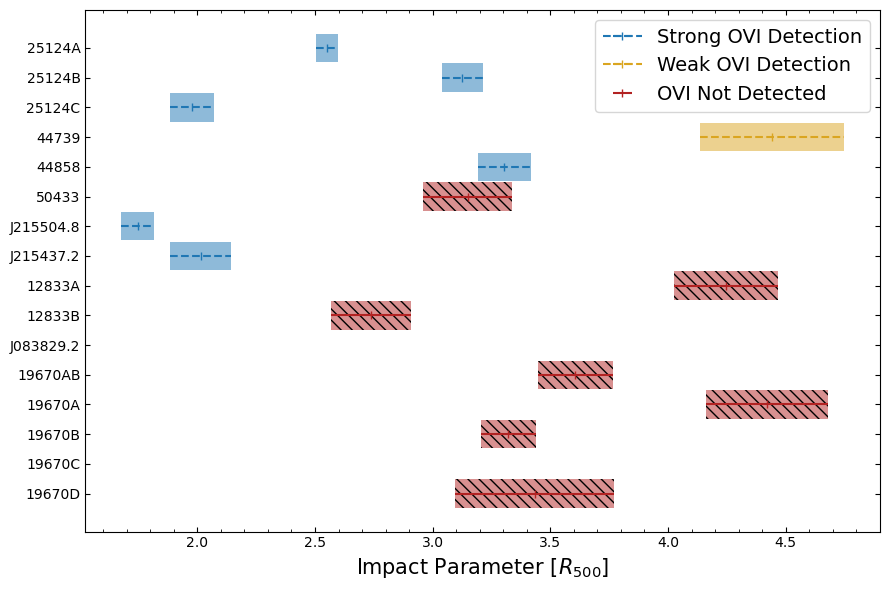

In [30]:
plt.figure(figsize=(9, 6))
ax = plt.gca()

plt.minorticks_on()
plt.tick_params(which='both', direction='in', top=True, right=True)
plt.tick_params(axis='y', which='minor', width=0)

plt.xlabel(r'Impact Parameter [$R_{500}$]', fontsize=15)

det_lab = False
not_det_lab = False
for row_ind, row in comb_ft.iterrows():
    rel_name = row['name'].split('-')[0].split('+')[0]
    d_rad = xr500_ft_scale_imp_fac[row_ind].value
    d_rad_err = xr500_ft_scale_imp_fac_err[row_ind].value
#     plt.axhline(row_ind-0.48, linestyle='dotted', color='tab:grey')
    
    if np.isnan(d_rad):
        continue


    if row['OVI_det']:
        if not det_lab:
            lab = 'Strong OVI Detection'
            det_lab = True
        else:
            lab = ''

        # This is a pretty shoddy way of doing this, but ah well
        if rel_name != '44739':
            errs = plt.errorbar(d_rad, row_ind, xerr=d_rad_err, fmt='|', color='tab:blue', linestyle='dashed', 
                                label=lab, capsize=0)
            errs[-1][0].set_linestyle('--')
            ax.fill_between([d_rad-d_rad_err, d_rad+d_rad_err], row_ind-0.48, row_ind+0.48, 
                                facecolor='tab:blue', alpha=0.5, interpolate=True)
        else:
            errs = plt.errorbar(d_rad, row_ind, xerr=d_rad_err, fmt='|', color='goldenrod', linestyle='dashed', 
                            label="Weak OVI Detection", capsize=0)
            errs[-1][0].set_linestyle('--')
            ax.fill_between([d_rad-d_rad_err, d_rad+d_rad_err], row_ind-0.48, row_ind+0.48, 
                            facecolor='goldenrod', alpha=0.5, interpolate=True)

    else:
        if not not_det_lab:
            lab = 'OVI Not Detected'
            not_det_lab = True
            
        else:
            lab = ''
        plt.errorbar(d_rad, row_ind, xerr=d_rad_err, fmt='|', color='firebrick', 
                    label=lab, capsize=0)
        ax.fill_between([d_rad-d_rad_err, d_rad+d_rad_err], row_ind-0.48, row_ind+0.48, 
                            facecolor='firebrick', alpha=0.5, interpolate=True, hatch="\\\\\\")
#     plt.axhspan(row_ind-0.48, row_ind+0.48, facecolor='none', edgecolor='black', linestyle='dotted')

chos_names = [n.split('-')[0].split('+')[0] if 'J' in n else n for n in comb_ft['name'].values]
plt.yticks(ticks=range(len(comb_ft)), labels=chos_names)
ax.invert_yaxis()
plt.legend(loc='best', fontsize=14)

plt.tight_layout()
plt.savefig("../../outputs/figures/xray_r500_froztemp_impact_par_werr.pdf")
plt.show()

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


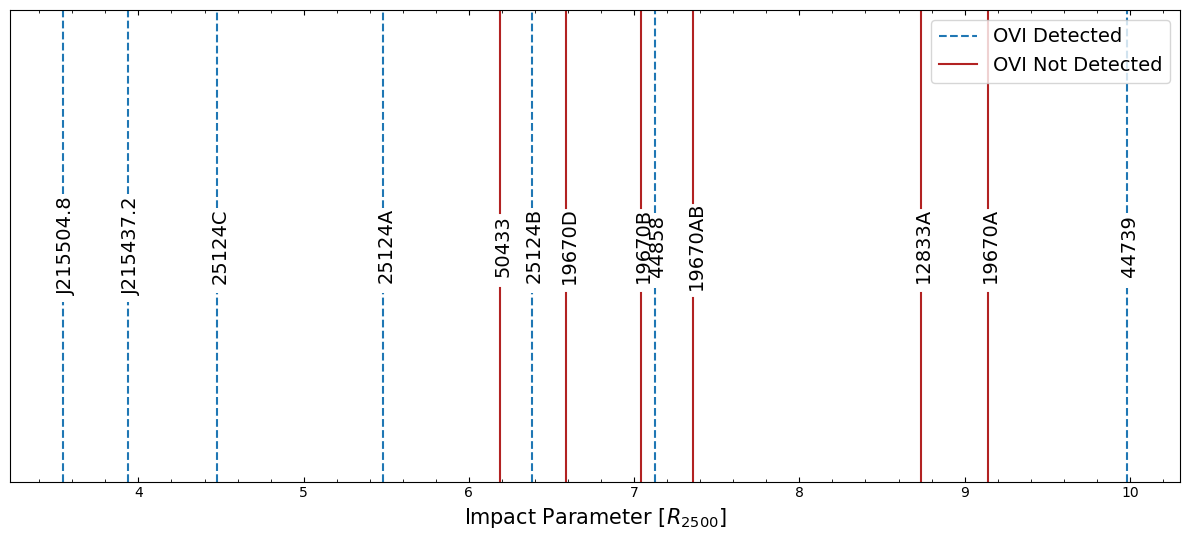

In [31]:
plt.figure(figsize=(12, 5.5))
ax = plt.gca()

plt.minorticks_on()
plt.tick_params(which='both', direction='in', top=True, right=True)

plt.xlabel(r'Impact Parameter [$R_{2500}$]', fontsize=15)

det_lab = False
not_det_lab = False
for row_ind, row in comb_ft.iterrows():
    rel_name = row['name'].split('-')[0].split('+')[0]
    
    d_rad = xr2500_ft_scale_imp_fac[row_ind].value
    ax.annotate(rel_name, (d_rad - 0.04, 0.5), rotation=90, verticalalignment='center', 
                color='black', fontsize=14, xycoords=('data', 'axes fraction'))
    if row['OVI_det']:
        if not det_lab:
            lab = 'OVI Detected'
            det_lab = True
        else:
            lab = ''
        plt.axvline(d_rad, color='tab:blue', linestyle='dashed', 
                    label=lab, ymax=y_stop_start[rel_name][0])
        plt.axvline(d_rad, color='tab:blue', linestyle='dashed', ymin=y_stop_start[rel_name][1], ymax=1)
    else:
        if not not_det_lab:
            lab = 'OVI Not Detected'
            not_det_lab = True
            
        else:
            lab = ''
        plt.axvline(d_rad, color='firebrick', label=lab, ymax=y_stop_start[rel_name][0])
        plt.axvline(d_rad, color='firebrick', ymin=y_stop_start[rel_name][1], ymax=1)

plt.yticks([])
plt.legend(loc=1, fontsize=14)
        
plt.tight_layout()
plt.savefig("../../outputs/figures/xray_r2500_froztemp_impact_par.pdf")
plt.show()

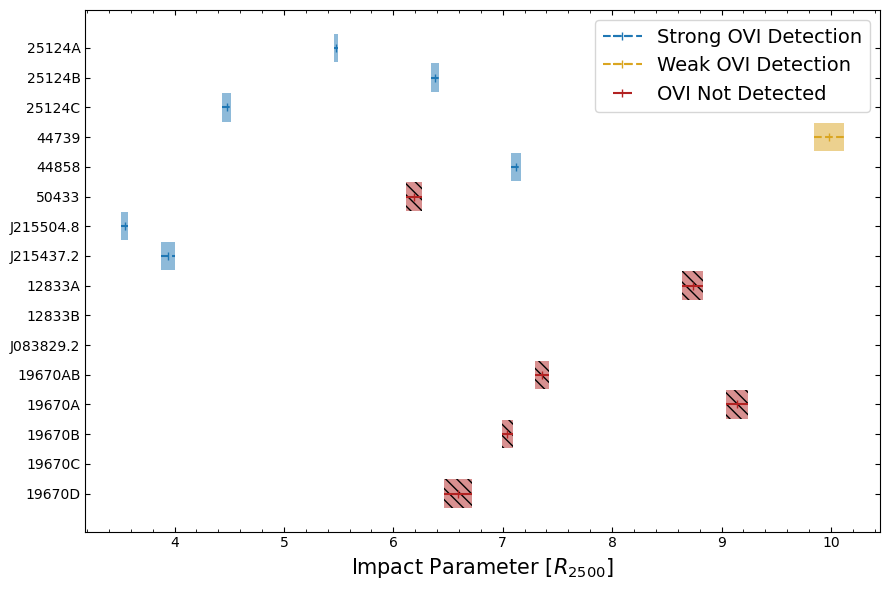

In [32]:
plt.figure(figsize=(9, 6))
ax = plt.gca()

plt.minorticks_on()
plt.tick_params(which='both', direction='in', top=True, right=True)
plt.tick_params(axis='y', which='minor', width=0)

plt.xlabel(r'Impact Parameter [$R_{2500}$]', fontsize=15)

det_lab = False
not_det_lab = False
for row_ind, row in comb_ft.iterrows():
    rel_name = row['name'].split('-')[0].split('+')[0]
    d_rad = xr2500_ft_scale_imp_fac[row_ind].value
    d_rad_err = xr2500_ft_scale_imp_fac_err[row_ind].value
#     plt.axhline(row_ind-0.48, linestyle='dotted', color='tab:grey')
    
    if np.isnan(d_rad):
        continue


    if row['OVI_det']:
        if not det_lab:
            lab = 'Strong OVI Detection'
            det_lab = True
        else:
            lab = ''

        # This is a pretty shoddy way of doing this, but ah well
        if rel_name != '44739':
            errs = plt.errorbar(d_rad, row_ind, xerr=d_rad_err, fmt='|', color='tab:blue', linestyle='dashed', 
                                label=lab, capsize=0)
            errs[-1][0].set_linestyle('--')
            ax.fill_between([d_rad-d_rad_err, d_rad+d_rad_err], row_ind-0.48, row_ind+0.48, 
                                facecolor='tab:blue', alpha=0.5, interpolate=True)
        else:
            errs = plt.errorbar(d_rad, row_ind, xerr=d_rad_err, fmt='|', color='goldenrod', linestyle='dashed', 
                            label="Weak OVI Detection", capsize=0)
            errs[-1][0].set_linestyle('--')
            ax.fill_between([d_rad-d_rad_err, d_rad+d_rad_err], row_ind-0.48, row_ind+0.48, 
                            facecolor='goldenrod', alpha=0.5, interpolate=True)

    
    # if row['OVI_det']:
    #     if not det_lab:
    #         lab = 'OVI Detected'
    #         det_lab = True
    #     else:
    #         lab = ''
        
    #     errs = plt.errorbar(d_rad, row_ind, xerr=d_rad_err, fmt='|', color='tab:blue', linestyle='dashed', 
    #                         label=lab, capsize=0)
    #     errs[-1][0].set_linestyle('--')
    #     ax.fill_between([d_rad-d_rad_err, d_rad+d_rad_err], row_ind-0.48, row_ind+0.48, 
    #                         facecolor='tab:blue', alpha=0.5, interpolate=True)
    else:
        if not not_det_lab:
            lab = 'OVI Not Detected'
            not_det_lab = True
            
        else:
            lab = ''
        plt.errorbar(d_rad, row_ind, xerr=d_rad_err, fmt='|', color='firebrick', 
                    label=lab, capsize=0)
        ax.fill_between([d_rad-d_rad_err, d_rad+d_rad_err], row_ind-0.48, row_ind+0.48, 
                            facecolor='firebrick', alpha=0.5, interpolate=True, hatch="\\\\\\")
#     plt.axhspan(row_ind-0.48, row_ind+0.48, facecolor='none', edgecolor='black', linestyle='dotted')

chos_names = [n.split('-')[0].split('+')[0] if 'J' in n else n for n in comb_ft['name'].values]
plt.yticks(ticks=range(len(comb_ft)), labels=chos_names)
ax.invert_yaxis()
plt.legend(loc='best', fontsize=14)

plt.tight_layout()
plt.savefig("../../outputs/figures/xray_r2500_froztemp_impact_par_werr.pdf")
plt.show()